<a href="https://colab.research.google.com/github/AtharvaGh/StartingOne/blob/main/Usecase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import pandas as pd
import numpy as np
from scipy import stats
from keras.layers import Dense,Flatten
from keras.models import sequential
from sklearn import preprocessing
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
def load_data(path):
  auto = pd.read_csv(path)
  print("Rows:",auto.shape[0],"Columns:",auto.shape[1])
  return(auto)
auto = load_data("/content/drive/MyDrive/Datasets/Train.csv")
auto.head(10)

Rows: 8068 Columns: 11


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C


Removing ID as it is not needed for analysis

In [36]:
auto = auto.drop(['ID'],axis=1)

Dealing with null values

In [37]:
auto.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

Using select data types to get the numeric columns so i can pass them to a function that replaces null values with their median

In [38]:
def mean_replace(df,columns):
  for c in columns:
    if df[c].isnull().sum()>0:
      df[c].fillna(value=df[c].mean(),inplace = True)
      print(c,":",df[c].isnull().sum())
  return(df)
columns = auto.select_dtypes(include=[np.number]).columns
auto = mean_replace(auto,columns)


Work_Experience : 0
Family_Size : 0


Using select data types to get the non-numeric columns so i can pass them to a function that replaces null values with their modes. This is fine in this dataset as all the non-numeric columns in the dataset are categorical in functionality


In [39]:
def mode_replace(df,columns):
  for c in columns:
    if df[c].isna().sum()>0:
      df[c].fillna(value=df[c].mode().iloc[0],inplace = True)
      print(c,":",df[c].isnull().sum())
    else:
      continue
  return(df)
columns = auto.select_dtypes(include='object').columns
auto = mode_replace(auto,columns)

Ever_Married : 0
Graduated : 0
Profession : 0
Var_1 : 0


In [40]:
auto.Profession.value_counts()

Artist           2640
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Name: Profession, dtype: int64

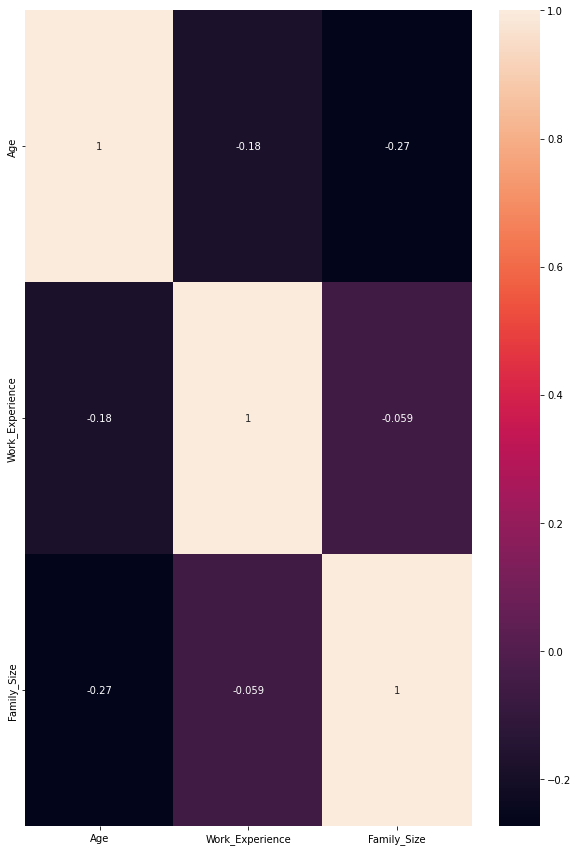

In [41]:
plt.figure(figsize=(10,15))
auto_corr = auto.corr()
sns.heatmap(auto_corr,annot=True)

In [42]:
auto.isnull().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

## Outlier detection

In [43]:
def z_score(df,columns):
  for c in columns:
    outliers = []
    z = np.abs(stats.zscore(df[c]))
    outliers = np.where(z>3)
    if len(outliers)>0:
      df.drop(outliers[0], inplace = True)
      print("Outliers for ",c,outliers[0],"have been removed")
  return(df)
columns = auto.select_dtypes(include=[np.number]).columns
auto = z_score(auto,columns)


Outliers for  Age [] have been removed
Outliers for  Work_Experience [  22   42   55  321  338  391  455  517  531  628  831  842  857  992
 1226 1232 1264 1549 1695 2025 2059 2193 2226 2258 2259 2267 2296 2388
 2421 2431 2722 2729 2792 2822 2837 3044 3055 3131 3177 3178 3243 3264
 3298 3757 3765 3767 3879 3902 3910 3979 4225 4312 4465 4685 4773 4784
 4869 4961 4978 5096 5313 5395 5492 5530 5531 5684 5728 5825 5992 5994
 6003 6039 6101 6158 6237 6518 6555 6730 6780 6793 6992 7205 7386 7397
 7663 7726 7798 7835 7990 8028 8043] have been removed
Outliers for  Family_Size [  25  147  199  289  339  708  856  927 1020 1280 1386 1430 1492 1529
 1585 1710 1883 1923 2286 2373 2436 2481 2538 2579 2617 2680 2686 2761
 2930 3000 3195 3318 3459 3463 3561 3563 3662 3671 3719 3848 3909 4198
 4372 4395 4427 4549 4577 4580 4644 4755 4891 4899 5019 5220 5307 5350
 5356 5493 5516 5615 5695 5989 6026 6196 6228 6258 6276 6295 6317 6526
 6547 6550 6572 6677 6799 6814 6829 6931 6966 7188 7265 7333 7413 745

In [44]:
mapp = [{'col':'Spending_Score','mapping':{'Low':1,'Average':2,'High':3}}]
encoder = ce.OrdinalEncoder(mapping = mapp, return_df = True)  
auto = encoder.fit_transform(auto)

## Binning

In [45]:
bins = [0,20,40,60,80,100]
auto['Age_range'] = pd.cut(auto['Age'],bins)


Label Encoding

In [46]:
classes = []
def labening(df,columns):
  for c in columns:
    l_en = preprocessing.LabelEncoder()
    df[columns]= l_en.fit_transform(df[columns])
    print(l_en.classes_)
  return(df,l_en.classes_)
  
#auto,c = labening(auto,'Var_1')
#classes.append(c)

In [47]:
def onehotencoding(df,columns):
  from sklearn.preprocessing import OneHotEncoder
  one_en = OneHotEncoder(sparse=False)
  for c in columns:
    df[c] = one_en.fit_transform(df[[c]])
  return(df)
columns = auto.select_dtypes(include='object').columns
columns = list(columns)
columns.remove('Segmentation')
columns.remove('Profession')
columns.remove('Var_1')
auto = onehotencoding(auto,columns)

In [48]:
auto.head(10)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_range
0,0.0,1.0,22,1.0,Healthcare,1.000000,1,4.0,Cat_4,D,"(20, 40]"
1,1.0,0.0,38,0.0,Engineer,2.641663,2,3.0,Cat_4,A,"(20, 40]"
2,1.0,0.0,67,0.0,Engineer,1.000000,1,1.0,Cat_6,B,"(60, 80]"
3,0.0,0.0,67,0.0,Lawyer,0.000000,3,2.0,Cat_6,B,"(60, 80]"
4,1.0,0.0,40,0.0,Entertainment,2.641663,3,6.0,Cat_6,A,"(20, 40]"
5,0.0,0.0,56,1.0,Artist,0.000000,2,2.0,Cat_6,C,"(40, 60]"
6,0.0,1.0,32,0.0,Healthcare,1.000000,1,3.0,Cat_6,C,"(20, 40]"
7,1.0,1.0,33,0.0,Healthcare,1.000000,1,3.0,Cat_6,D,"(20, 40]"
8,1.0,0.0,61,0.0,Engineer,0.000000,1,3.0,Cat_7,D,"(60, 80]"
9,1.0,0.0,55,0.0,Artist,1.000000,2,4.0,Cat_6,C,"(40, 60]"


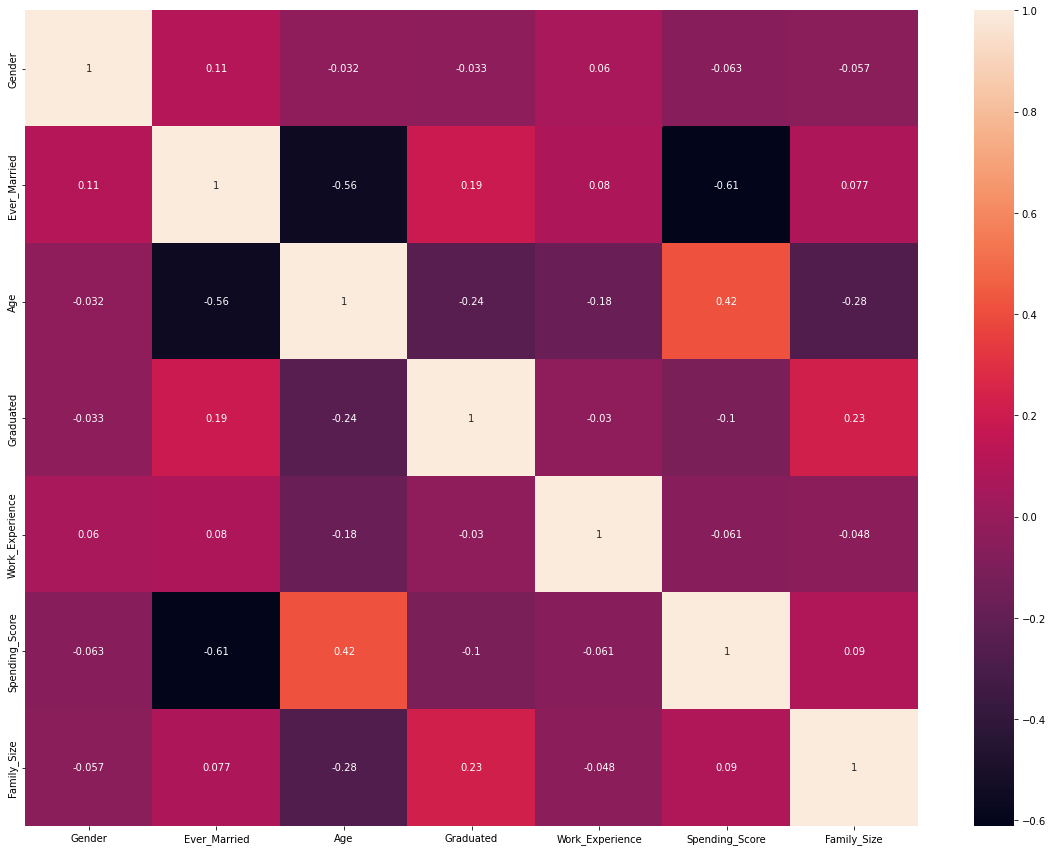

In [49]:
plt.figure(figsize=(20,15))
auto_corr = auto.corr()
sns.heatmap(auto_corr,annot=True)

## Analysis

[Text(0.5, 1.0, 'Which segemnts have individuals with low spending')]

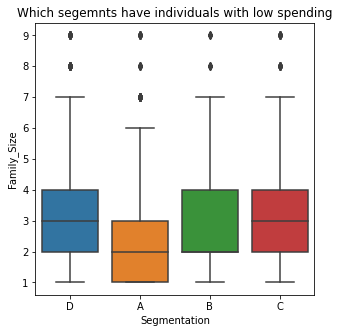

In [50]:
#Which segemnts have individuals with low spending?
plt.figure(figsize=(5,5))
sns.boxplot(x='Segmentation',y='Family_Size',data=auto).set(title='Which segemnts have individuals with low spending')

[Text(0.5, 1.0, 'Which Age range have greater number of graduates')]

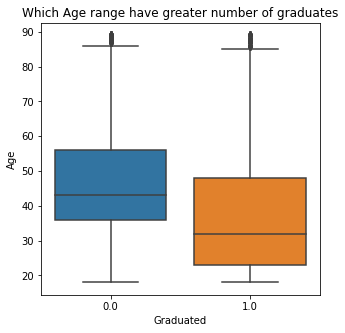

In [51]:
#Which Age range have greater number of graduates?
plt.figure(figsize=(5,5))
sns.boxplot(x='Graduated',y='Age',data=auto).set
(title='Which Age range have greater number of graduates')

[Text(0.5, 1.0, 'For family sizes between 2-4 what is the average spending by profession')]

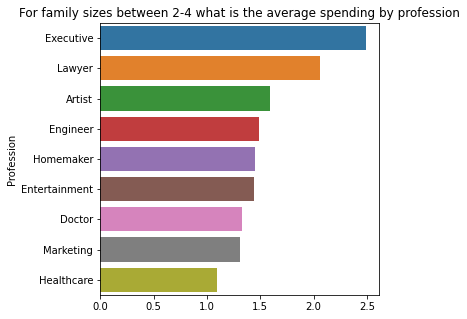

In [52]:
#Which profession has highest work experience
fam = np.where((auto['Family_Size'] <= 4))
auto2 = auto[auto.index.isin(fam[0])]
auto_sum = auto2.groupby(by="Profession")['Spending_Score'].mean()
auto_sum.sort_values(ascending=False,inplace=True)
plt.figure(figsize=(5,5))
sns.barplot(y=auto_sum.keys(),x=auto_sum.values).set
(title="For family sizes between 2-4 what is the average spending by profession")

[Text(0.5, 1.0, 'Which segment has the highest Spending score?')]

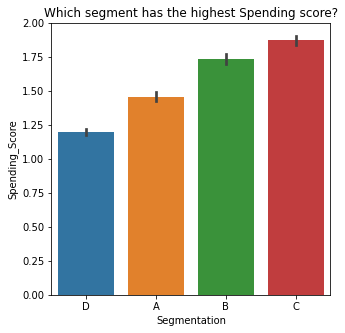

In [53]:
#Which segment has the highest Spending score
plt.figure(figsize=(5,5))
sns.barplot(y=auto['Spending_Score'],x=auto['Segmentation']).set(title = "Which segment has the highest Spending score?")

<Figure size 360x360 with 0 Axes>

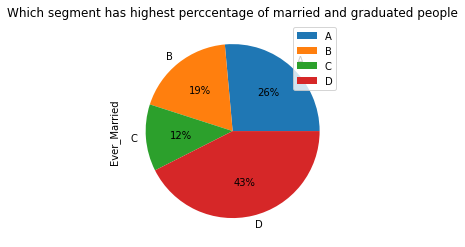

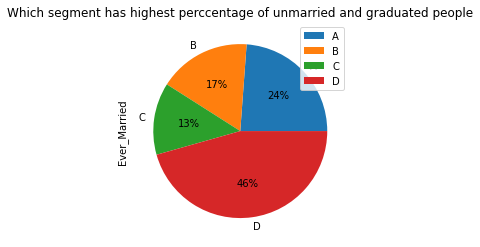

In [54]:
#Which segment has highest perccentage of married and graduated people
plt.figure(figsize=(5,5))
married_yes = np.where((auto['Ever_Married'] == 1.0) & (auto['Graduated'] == 1.0))
married_no = np.where((auto['Ever_Married'] == 0.0) & (auto['Graduated'] == 1.0))
pie1 = auto[auto.index.isin(married_yes[0])]
pie2 = auto[auto.index.isin(married_no[0])]
pie1.groupby(['Segmentation']).mean().plot
(kind='pie', y='Ever_Married',autopct='%1.0f%%',title="Which segment has highest perccentage of married and graduated people")
pie2.groupby(['Segmentation']).mean().plot
(kind='pie', y='Ever_Married',autopct='%1.0f%%',title="Which segment has highest perccentage of unmarried and graduated people")

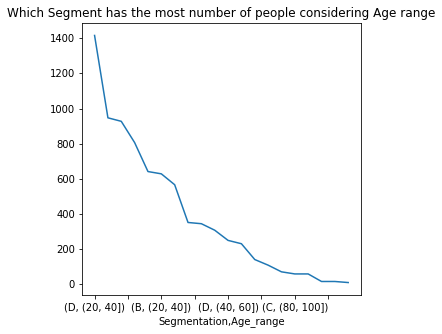

In [55]:
#Which Segment has the most number of people considering Age range
plt.figure(figsize=(5,5))
auto[["Segmentation","Age_range"]].value_counts(sort = True).plot
(kind="line",title="Which Segment has the most number of people considering Age range")

## Feature Engineering


In [56]:
auto.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_range
0,0.0,1.0,22,1.0,Healthcare,1.000000,1,4.0,Cat_4,D,"(20, 40]"
1,1.0,0.0,38,0.0,Engineer,2.641663,2,3.0,Cat_4,A,"(20, 40]"
2,1.0,0.0,67,0.0,Engineer,1.000000,1,1.0,Cat_6,B,"(60, 80]"
3,0.0,0.0,67,0.0,Lawyer,0.000000,3,2.0,Cat_6,B,"(60, 80]"
4,1.0,0.0,40,0.0,Entertainment,2.641663,3,6.0,Cat_6,A,"(20, 40]"


In [57]:
auto,c = labening(auto,'Age_range')

[Interval(0, 20, closed='right') Interval(20, 40, closed='right')
 Interval(40, 60, closed='right') Interval(60, 80, closed='right')
 Interval(80, 100, closed='right')]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]


In [58]:
def getdum(df,c):
  one_hot_encoded_data = pd.get_dummies(df, columns = c)
  return(one_hot_encoded_data)
d = getdum(auto,['Profession'])

In [59]:
d2 = getdum(d,['Var_1'])

In [60]:
d3 = getdum(d2,['Segmentation'])

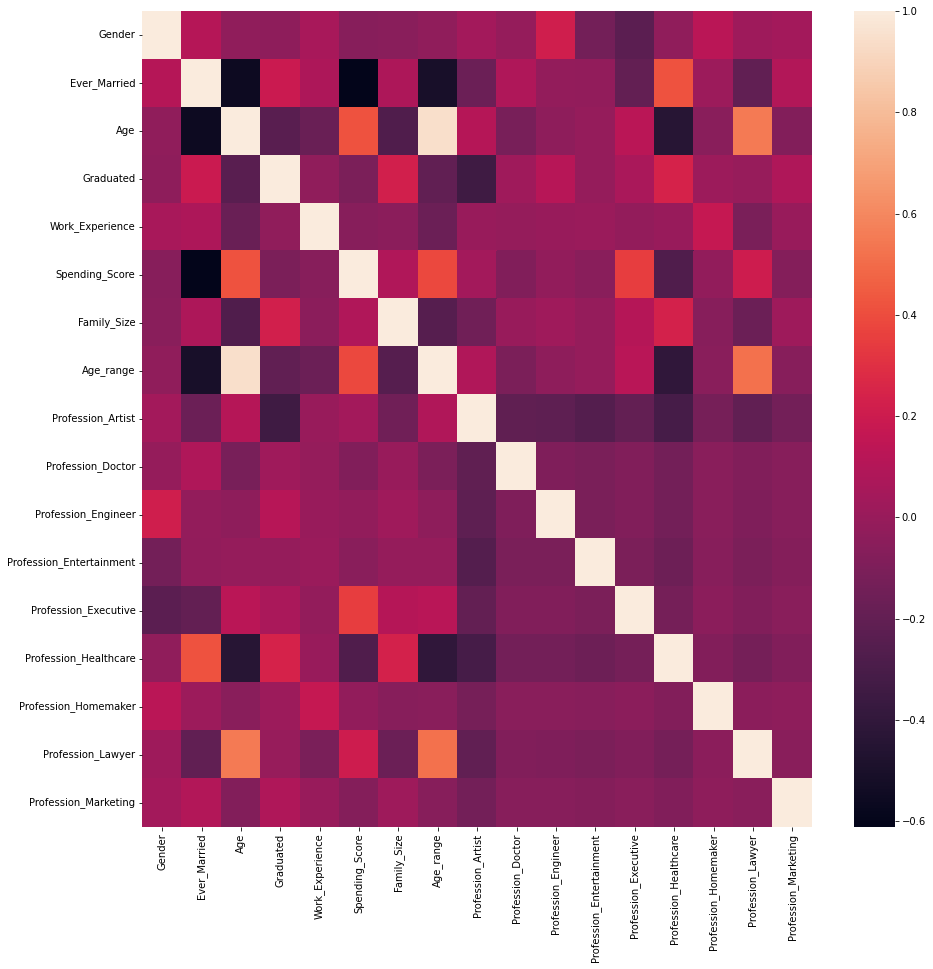

In [61]:
plt.figure(figsize=(15,15))
auto_corr = d.corr()
sns.heatmap(auto_corr)

In [62]:
auto.drop(columns = 'Age',axis=0,inplace=True)

## Test Data

In [65]:
auto_t = pd.read_csv('/content/drive/MyDrive/Datasets/Test.csv')
#Dropping ID columns
auto_t = auto_t.drop(['ID'],axis=1)
#Dealing with null values. For numerical columns, mean replace is used while for ctegorical model replcaement is used
columns = auto_t.select_dtypes(include=[np.number]).columns
auto_t = mean_replace(auto_t,columns)
columns = auto_t.select_dtypes(include='object').columns
auto_t = mode_replace(auto_t,columns)
# Finding outliers in numerical columns
columns = auto_t.select_dtypes(include=[np.number]).columns
auto_t = z_score(auto_t,columns)
#Creating a columns for age range by binning age column
bins = [0,20,40,60,80,100]
auto_t['Age_range'] = pd.cut(auto_t['Age'],bins)
#Label encoding
classes2 = []
#auto_t,c = labening(auto_t,['Var_1'])
#classes2.append(c)
#One hot encoding
columns = auto_t.select_dtypes(include='object').columns
columns = list(columns)
columns.remove('Segmentation')
columns.remove('Profession')
columns.remove('Var_1')
auto_t = onehotencoding(auto_t,columns)
#next labeling
auto_t,c = labening(auto_t,'Age_range')
#Get dummies for machine learning
t1 = getdum(auto_t,['Profession'])
t2 = getdum(t1,['Var_1'])
t3 = getdum(t2,['Segmentation'])
#Column replacement
t3.columns = d3.columns

Work_Experience : 0
Family_Size : 0
Ever_Married : 0
Graduated : 0
Profession : 0
Var_1 : 0
Outliers for  Age [] have been removed
Outliers for  Work_Experience [ 182  188  297  371  402  403  412  432  601  893  994 1104 1211 1389
 1527 1544 1551 1619 1630 1682 1772 1830 1842 1945 2022 2060 2303 2403
 2507 2528 2583 2604] have been removed
Outliers for  Family_Size [  40  164  305  566  638  691  808  939  960  962 1026 1029 1059 1068
 1447 1464 1595 1643 1648 1678 1705 1706 1737 1890 1892 1978 1981 2487
 2534 2550] have been removed
[Interval(0, 20, closed='right') Interval(20, 40, closed='right')
 Interval(40, 60, closed='right') Interval(60, 80, closed='right')
 Interval(80, 100, closed='right')]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]


In [83]:
t3.head(3)

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Age_range,Profession_Artist,Profession_Doctor,...,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation_A,Segmentation_B,Segmentation_C,Segmentation_D
0,1.0,0.0,36,0.0,0.0,0.0,1.0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1,0.0,0.0,37,0.0,8.0,1.0,4.0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
2,1.0,0.0,69,1.0,0.0,0.0,1.0,3,1,0,...,0,0,0,0,1,0,1,0,0,0


In [66]:
Xtr = d3.iloc[:,:-4]
Ytr = d3.iloc[:,-4:]
Xte = t3.iloc[:,:-4]
Yte = t3.iloc[:,-4:]

In [ ]:
#from sklearn.model_selection import train_test_split
#X_train,Y_train = train_test_split(Xtr,Ytr,random_state=5)

In [67]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(Xtr)
X_test = sc.transform(Xte)

## Modeling

In [68]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid

In [69]:
def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=X_train.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
    model.add(Dense(4)) # Note: no activation beyond this point
    
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return model
    
model = KerasClassifier(build_fn=create_model, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  from ipykernel import kernelapp as app


In [71]:
layers = [[20], [40, 20], [45, 30, 15]]
activations = ['softmax', 'relu']
param_grid = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[30])
grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [72]:
grid_result = grid.fit(Xtr, Ytr)

In [73]:
[grid_result.best_score_,grid_result.best_params_]

[0.33443245887756345,
 {'activation': 'softmax', 'batch_size': 128, 'epochs': 30, 'layers': [20]}]

In [80]:
model = Sequential()
model.add(Dense(45,input_dim=24,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(4,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [81]:
model.fit(Xtr,Ytr,epochs=3000,batch_size=128,verbose=1)

Streaming output truncated to the last 5000 lines.
62/62 [==============================] - 0s 2ms/step - loss: 0.9774 - accuracy: 0.5637
Epoch 502/3000
62/62 [==============================] - 0s 2ms/step - loss: 0.9741 - accuracy: 0.5626
Epoch 503/3000
62/62 [==============================] - 0s 2ms/step - loss: 0.9743 - accuracy: 0.5597
Epoch 504/3000
62/62 [==============================] - 0s 3ms/step - loss: 0.9740 - accuracy: 0.5613
Epoch 505/3000
62/62 [==============================] - 0s 2ms/step - loss: 0.9856 - accuracy: 0.5524
Epoch 506/3000
62/62 [==============================] - 0s 2ms/step - loss: 0.9771 - accuracy: 0.5623
Epoch 507/3000
62/62 [==============================] - 0s 3ms/step - loss: 0.9760 - accuracy: 0.5621
Epoch 508/3000
62/62 [==============================] - 0s 2ms/step - loss: 0.9783 - accuracy: 0.5617
Epoch 509/3000
62/62 [==============================] - 0s 2ms/step - loss: 0.9750 - accuracy: 0.5645
Epoch 510/3000
62/62 [========================

In [87]:
y_pred = model.predict(Xte)

In [88]:
y_pred

array([[1.6121607e-01, 8.3740622e-01, 9.9012113e-06, 1.3678477e-03],
       [1.2446088e-01, 1.0042680e-02, 4.7277551e-02, 8.1821883e-01],
       [2.2572857e-01, 1.7592840e-01, 4.6356267e-01, 1.3478033e-01],
       ...,
       [2.7609348e-01, 2.1551226e-03, 1.0875096e-09, 7.2175145e-01],
       [3.7132126e-01, 6.6184685e-02, 4.8225354e-03, 5.5767149e-01],
       [5.4000169e-02, 4.8712487e-03, 2.5011728e-02, 9.1611683e-01]],
      dtype=float32)

In [89]:
from sklearn.metrics import confusion_matrix
Y_pred=np.argmax(y_pred, axis=1)
Y_test_r=np.argmax(Yte.values, axis=1)
cm = confusion_matrix(Y_test_r, Y_pred)
print(cm)

[[196 115  93 415]
 [149  79  68 241]
 [130  71  63 203]
 [123  90  90 439]]


In [90]:
cm_df = pd.DataFrame(cm,index = ['A','B','C','D'], columns = ['A','B','C','D'])

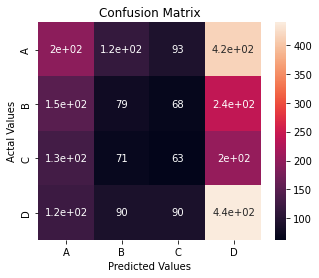

In [92]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Overall the model was not a good fit 
## Better feature engineering technique need to be used
